# SeNet-cifar10-pytorch

In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms
import time

device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [3]:
torch.torch.ones(10)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [8]:
# 超参数
EPOCHS = 40
BATCH_SIZE = 128
LEARNING_RATE = 1e-1
WEIGHT_DECAY = 1e-4

## 获取数据

使用`torchvision.dataset`获取数据

In [9]:
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]))
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
]))

Files already downloaded and verified
Files already downloaded and verified


In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## 定义SeNet模型

In [11]:
# Squeeze and Excitation Block Module
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels * 2, 1, bias=False),
        )

    def forward(self, x):
        w = F.adaptive_avg_pool2d(x, 1) # Squeeze
        w = self.fc(x)
        w, b = w.split(w.data.size(1) // 2, dim=1) # Excitation
        w = torch.sigmoid(w)

        return x * w + b # Scale and add bias


In [12]:
# Residual Block with SEBlock
class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()

        self.conv_lower = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU()
        )

        self.conv_upper = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(channels)
        )

        self.se_block = SEBlock(channels)

    def forward(self, x):
        path = self.conv_lower(x)
        path = self.conv_upper(path)

        path = self.se_block(path)

        path = x + path
        return F.relu(path)

In [13]:
# Network Module
class Network(nn.Module):
    def __init__(self, in_channel, filters, blocks, num_classes):
        super(Network, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channel, filters, 3, padding=1, bias=False),
            nn.BatchNorm2d(filters),
            nn.ReLU()
        )

        self.res_blocks = nn.Sequential(*[ResBlock(filters) for _ in range(blocks - 1)])

        self.out_conv = nn.Sequential(
            nn.Conv2d(filters, 128, 1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv_block(x)
        x = self.res_blocks(x)
        
        x = self.out_conv(x)
        x = F.adaptive_avg_pool2d(x, 1)

        x = x.view(x.data.size(0), -1)
        x = self.fc(x)

        return F.log_softmax(x, dim=1)

## 训练模型 

In [14]:
net = Network(3, 128, 10, 10).to(device)

ACE = nn.CrossEntropyLoss().to(device)
opt = optim.SGD(net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, momentum=.9, nesterov=True)

In [22]:
for epoch in range(1, EPOCHS + 1):
  print('[Epoch %d]' % epoch)
  
  train_loss = 0
  train_correct, train_total = 0, 0

  start_point = time.time()

  for inputs, labels in train_loader:
    inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

    opt.zero_grad()

    preds = net(inputs)
    
    loss = ACE(preds, labels)
    loss.backward()

    opt.step()

    train_loss += loss.item()

    train_correct += (preds.argmax(dim=1) == labels).sum().item()
    train_total += len(preds)

  print('train-acc : %.4f%% train-loss : %.5f' % (100 * train_correct / train_total, train_loss / len(train_loader)))
  print('elapsed time: %ds' % (time.time() - start_point))

  test_loss = 0
  test_correct, test_total = 0, 0

  for inputs, labels in test_loader:
    with torch.no_grad():
      inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

      preds = net(inputs)

      test_loss += ACE(preds, labels).item()

      test_correct += (preds.argmax(dim=1) == labels).sum().item()
      test_total += len(preds)

  print('test-acc : %.4f%% test-loss : %.5f' % (100 * test_correct / test_total, test_loss / len(test_loader)))
  
  torch.save(net.state_dict(), './data/checkpoint/checkpoint-%04d.bin' % epoch)

[Epoch 1]
train-acc : 62.9240% train-loss : 1.02725
elapsed time: 167s
test-acc : 59.9800% test-loss : 1.13711
[Epoch 2]
train-acc : 69.3160% train-loss : 0.85710
elapsed time: 170s
test-acc : 67.6300% test-loss : 0.92139
[Epoch 3]
train-acc : 73.9000% train-loss : 0.74356
elapsed time: 171s
test-acc : 70.7700% test-loss : 0.84002
[Epoch 4]
train-acc : 77.2340% train-loss : 0.65098
elapsed time: 171s
test-acc : 74.3400% test-loss : 0.75001
[Epoch 5]
train-acc : 79.7560% train-loss : 0.58424
elapsed time: 171s
test-acc : 74.8000% test-loss : 0.71813
[Epoch 6]
train-acc : 81.8820% train-loss : 0.52713
elapsed time: 171s
test-acc : 77.7400% test-loss : 0.66449
[Epoch 7]
train-acc : 83.0260% train-loss : 0.49098
elapsed time: 171s
test-acc : 79.3000% test-loss : 0.60599
[Epoch 8]
train-acc : 84.2880% train-loss : 0.45633
elapsed time: 171s
test-acc : 78.0500% test-loss : 0.64819
[Epoch 9]
train-acc : 85.2660% train-loss : 0.43147
elapsed time: 171s
test-acc : 80.7400% test-loss : 0.57734
[

## 导入保存的模型

In [15]:
net.load_state_dict(torch.load('data\\checkpoint\\checkpoint-0040.bin', map_location=torch.device('cpu')))
net.eval()

Network(
  (conv_block): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (res_blocks): Sequential(
    (0): ResBlock(
      (conv_lower): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv_upper): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (se_block): SEBlock(
        (fc): Sequential(
          (0): Conv2d(128, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): ReLU()
          (2): Conv2d(8, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
      

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
sns.set()

In [17]:
for images, labels in test_loader:
    pred = torch.argmax(net(images), axis=1)
    print('confusion_matrix: \n', confusion_matrix(pred, labels))
    print('accuracy_score:', accuracy_score(pred, labels))
    print('precision_score:', precision_score(pred, labels, average='micro'))
    print('f1-score:', f1_score(pred, labels, average='micro'))
    break

confusion_matrix: 
 [[11  0  0  0  0  0  0  0  1  0]
 [ 0  9  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  1  2  0  0  0  0]
 [ 0  0  1 11  0  0  0  1  0  0]
 [ 0  0  0  1  9  0  0  0  0  0]
 [ 0  0  0  1  0  7  1  0  0  0]
 [ 0  0  0  0  0  0 18  0  0  0]
 [ 1  0  0  2  0  0  0 12  0  0]
 [ 1  0  0  0  0  0  0  0 16  0]
 [ 0  1  0  0  0  0  0  0  0 11]]
accuracy_score: 0.890625
precision_score: 0.890625
f1-score: 0.890625


In [18]:
pred

tensor([3, 8, 8, 8, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 0, 6, 7, 0, 4, 9,
        2, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 3, 4, 9, 9, 5, 4, 6, 5, 6, 0, 9, 4, 9,
        7, 6, 9, 8, 7, 3, 8, 8, 7, 3, 2, 5, 7, 5, 6, 3, 6, 2, 1, 2, 7, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 7, 8, 8, 1, 1, 7, 2, 2, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7,
        8, 3, 1, 2, 8, 0, 8, 3])

In [28]:
conf_mat = confusion_matrix(labels, pred)
conf_mat

array([[11,  0,  0,  0,  0,  0,  0,  1,  1,  0],
       [ 0,  9,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0, 10,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 11,  1,  1,  0,  2,  0,  0],
       [ 0,  0,  1,  0,  9,  0,  0,  0,  0,  0],
       [ 0,  0,  2,  0,  0,  7,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1, 18,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0, 12,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0, 16,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 11]], dtype=int64)

In [33]:
df = pd.DataFrame(conf_mat, index=test_dataset.classes, columns=test_dataset.classes)
df

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,11,0,0,0,0,0,0,1,1,0
automobile,0,9,0,0,0,0,0,0,0,1
bird,0,0,10,1,0,0,0,0,0,0
cat,0,0,0,11,1,1,0,2,0,0
deer,0,0,1,0,9,0,0,0,0,0
dog,0,0,2,0,0,7,0,0,0,0
frog,0,0,0,0,0,1,18,0,0,0
horse,0,0,0,1,0,0,0,12,0,0
ship,1,0,0,0,0,0,0,0,16,0
truck,0,0,0,0,0,0,0,0,0,11


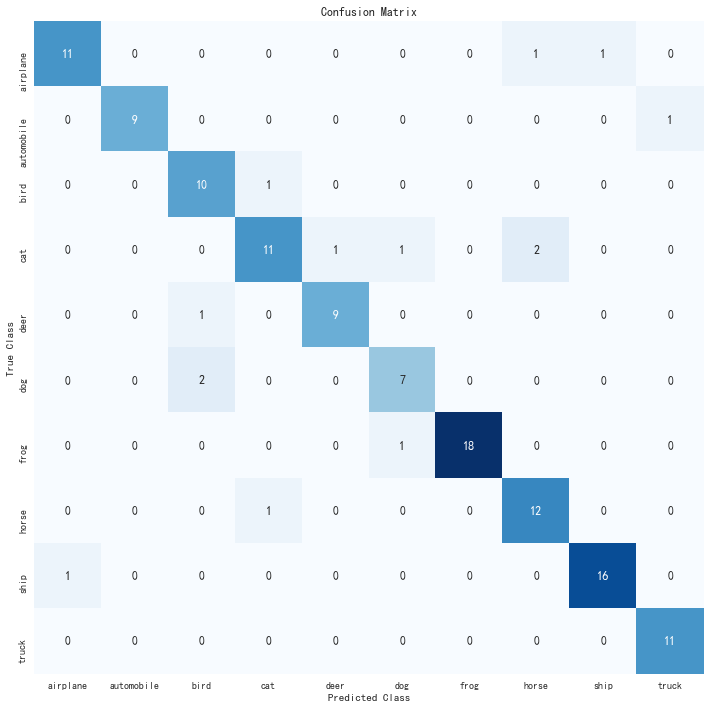

In [42]:
# 绘制混淆矩阵图
plt.figure(figsize=(12, 12))
plt.rcParams['font.sans-serif']=['SimHei']
sns.heatmap(df, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()